In [57]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
import control
import cmath
from pylab import *


In [58]:
MAX_VOLTAGE = 10.0                   # [V]
R = 2.41                             # Coil Resistance [ohms]
L = 0.015266817305695372             # Inductance [H]
c_I_to_V_h = 0.47996355000000007     # Computed scaling constant between electromagnet current and hall voltage
# Lumped parameter constants for V_h to position
hall_params = [2.58897620e-05, 2.49441669e+00, 1.35761509e-02]

# Lumped paramter in electromagnet current to position model
C1 = -0.0000025 # Hand-picked for now

# For computing hall voltage contribution from magnet
C2 = 0.86 # Electromagnet voltage scaling
C3 = 0.39 # Current derivative scaling

# Linearization setpoints
I_bar = 1.5 # Note: magnet will be pre-charged to this value
y_bar = 0.025 # Note: this is the point where we will try to control around


m = C1 * I_bar / (-9.81*L*4*math.pi*y_bar**2) # Set mass such that it offsets the magnetic force at setpoint

In [59]:
a2 = (C1 * I_bar) / (m * L * 2 * np.pi * y_bar**3)
np.sqrt(np.abs(a2)) # pole locations of second plant (+/-)

28.014282071829005

In [60]:
a1 = (-C1 * I_bar) / (m * 4 * np.pi * y_bar**2)

In [61]:
- R / L # pole locations of first plant

-157.85870438764837

## Root Locus Plots

#### Root Locus Plot of the Magnet Model

To validate our model of the magnetic system, we created a root locus plot of the transfer function of the magnetic system:

$$ G_e = \frac{a_1}{s^2+a_2} $$

This plot gives us two poles at $\pm \sqrt{a2}$, indicating that our magnetic system is unstable when it is not controlled. Which alligns with a physical understanding that the magnet will either stick to the electro-magnet at the top or fall down to the bottom.

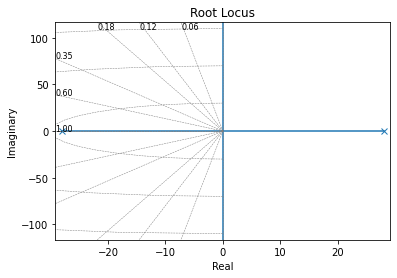

In [62]:
lti_uncontrolled = control.TransferFunction([a1], [1, 0, a2])
rlist, klist = control.root_locus(lti_uncontrolled)
plt.show()

#### Root Locus Plot of the Plant

After validating our magnet model, we created a root locus plot of our full plant, combining the transfer function of the circuit with the transfer function of the magnet. This gave us the transfer function, G, below:

$$ G_c = \frac{1}{R+Ls}$$
$$ G_e = \frac{a_1}{s^2+a_2} $$
$$ G = G_c*G_e = \frac{a_1}{Ls^3+Rs^2+La_2s+Ra_2}$$

This plot gives us the two poles, $\pm \sqrt{a2} \approx \pm 28$, from our magnetic model, plus an additional pole at $-R/L \approx -157$.  This system is always unstable, indicating the need for a controller

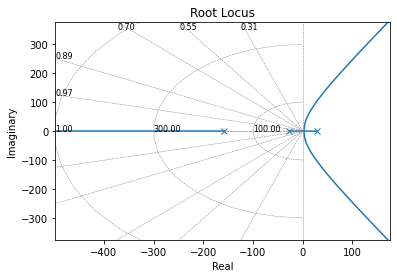

In [63]:
lti_uncontrolled = control.TransferFunction([a1], [L, R, L*a2, R*a2])
rlist, klist = control.root_locus(lti_uncontrolled)
plt.show()

#### Designing our controller

In order to create a stable closed-loop system, we need a way to pull the poles of the closed loop system onto the left hand plane of the root locus plot. To do this we wanted to increase the ratio of zeros to poles, which can be done using both PD and PID controllers. We created quick sketches of potential root locus plots to explore different options for these two controllers. From looking at these root locus plots, we could see that when using a PID controller, in order for the system to be stable, oscillations must occur. When using a PD controller it is possible to have a stable system with no osscillations, and since our primary goal is to just get the magnet to float, we are not concerned with steady state error, one of the common downsides of PD controllers. For this reason we decided to implement a PD controller with our system, specifically aiming for the first plot, where the zero is inbetween the two  $\pm \sqrt{a2}$ poles.


<img src="./images/PD-PID_root_locus.JPG" width="80%">

#### Open Loop Transfer Function

After deciding to implement a PD controller, we created an open loop transfer function $TF_{OL}$.

$$ G = \frac{a_1}{Ls^3+Rs^2+La_2s+Ra_2}$$

$$ C_{PD} = K_P + K_Ds $$ 

$$ TF_{OL} = G*C_{PD} = \frac{a_1 K_D s + a_1 K_P}{Ls^3+Rs^2+La_2s+Ra_2}$$

#### Placing the Controller Pole

By implementing a PD controller we add one additional pole to our system, at a value of $\frac{-K_p}{K_d}$.  In order to have the fastest time response, we wanted to place this pole close to the $-\sqrt{a2}$, but on the right of it. With  $-\sqrt{a2} \approx -28 $, we chose to have $\frac{-K_p}{K_d} = -27$, in order to have ths zero close to that pole, but not on top of it to avoid pole-zero cancellation. This gave us the root locus plot below:

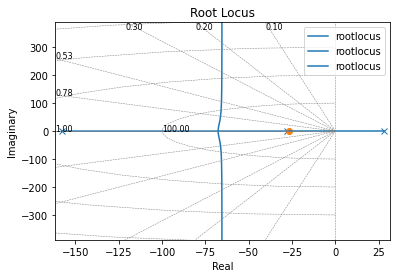

In [64]:
k = 855
kp = k*27
kd = k*1

lti = control.TransferFunction([a1*kd, a1*kp], [L, R, L*a2, R*a2])
rlist, klist = control.root_locus(lti)
plt.legend()
plt.show()

#### Bode Plot
With the proportional relationship between $K_p$ and $K_d$ determined, we then turned to the Bode plot to determine an overall gain, k, of the system. From the phase bode plot we got that the cross over frequency occurs at 0 Hz, since the system starts out with a phase of $-\pi$. This means that as long as we achieve a DC gain greater than 1, our system will be stable. We found that this is possible with any k greater than 600(but the plots below are with our final k of 855).

In [65]:
f = np.logspace(-1,5)
w = 1*np.pi*f
mag, phase, w = control.bode(lti,w, dB = False, plot = False)
gm, pm, sm, wg, wp, ws = control.stability_margins(lti)

Gain Margin =  0.5470520403297323


Text(0.5, 1.0, 'Magnitude Bode Plot')

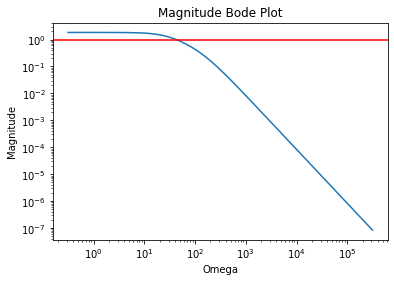

In [66]:
print("Gain Margin = ", gm)
loglog(w,mag)
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=wg, color='r', linestyle='-')
plt.xlabel("Omega")
plt.ylabel("Magnitude")
plt.title("Magnitude Bode Plot")

omega_crossover = 0.0


Text(0.5, 1.0, 'Phase Bode Plot')

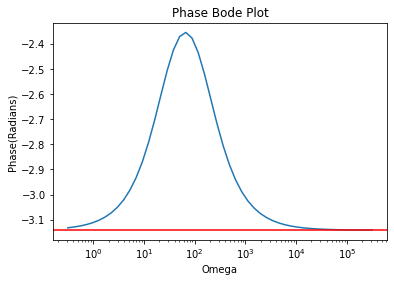

In [67]:
print("omega_crossover =", wg )
semilogx(w,phase)
plt.axhline(y=-np.pi, color='r', linestyle='-')
plt.axvline(x=wg, color='r', linestyle='-')
plt.xlabel("Omega")
plt.ylabel("Phase(Radians)")
plt.title("Phase Bode Plot")

#### Final k tuning and system validation
Through looking at the bode plots we determined that the system will be stable as long as k is greater than 600, however we wanted to ensure that our system had the fastest possible time response, while avoiding oscillations. To do this we calculated the closed loop transfer function.

Since we are modeling our system with unity feedback, we get the closed loop transfer function as:

$$ TF_{CL} = \frac{GC}{1+GC} = \frac{a_1 K_D s + a_1 K_P}{(Ls^3+Rs^2+La_2s+Ra_2) + (a_1 K_D s + a_1 K_P)}$$ 

We used the closed loop transfer function as a way to validate the positions of our final poles, and ended up tuning our k value to 855 as this ensured that we had a quick time response while also preventing the system from ossilating.

In [68]:
TFcl = control.TransferFunction([a1*kd, a1*kp], [L, R, L*a2 + a1*kd, R*a2 + a1*kp])
TFcl_poles = control.pole(TFcl)
TFcl_poles_real = np.real(TFcl_poles)
TFcl_poles_imag = np.imag(TFcl_poles)

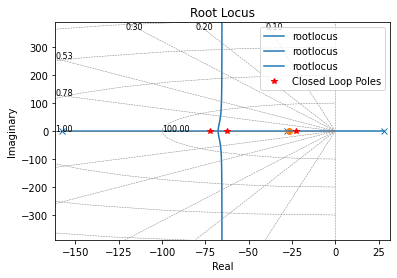

In [69]:
asymptote = ((-R/L)-(-kp/kd))
 
    
lti = control.TransferFunction([a1*kd, a1*kp], [L, R, L*a2, R*a2])
rlist, klist = control.root_locus(lti)
plt.plot(TFcl_poles_real, TFcl_poles_imag, 'r*', label = "Closed Loop Poles")
plt.legend()
plt.show()